In [ ]:
# Run a large number of trajectories and then compress to the closest macrostate discovered with small box

In [2]:
import math
import numpy as np
import nupack4
from nupack4 import State, Model
import scipy.stats
#from nupack4.kinetics import Sim_Timer

In [3]:
# Gives a structure matrix from dotprint
def structure_matrix(seq):
    lengd = len(seq)
    leftB = []
    rightB = []
    Smatrix = np.zeros([lengd,lengd])
    
    for i in range(lengd):
        if seq[i] == '(':
            leftB.append(i)
        elif seq[i] == ')':
            rightB.append(i)
        
    for x,y in list(enumerate(leftB)):
        Smatrix[y,rightB[len(rightB)-1-x]] = 1
        Smatrix[rightB[len(rightB)-1-x], y] = 1
    Smatrix += np.diag(1-Smatrix.sum(0))
    return Smatrix

In [4]:
# Finds pair probability
def pair_probability(small_pi, w, i):
    '''Takes in secondary structure and stationary distribution and gives out the pair probability matrix'''
    P = small_pi[i]*structure_matrix(w)
    return P

In [5]:
# Extra function to compress full set of all states to the discovered macrostate that has the closest pair probability
# matrix
def change_to_macro(PP_Matrix_Collector, macro_States, all_states, small_pi):
    
    P_2 = []
    
    for i in range(len(macro_States)):
        for k in range(len(all_states)):
            if macro_States[i] == all_states[k].dp:
                P_2.append(pair_probability(small_pi, macro_States[i], k))
    

    
    TimeCollector = []
    for i in range(len(PP_Matrix_Collector)):                         # Every time step
        vec_counter = np.zeros(len(macro_States))
        for j in range(len(PP_Matrix_Collector[i])):                  # Every iteration, matrix
            P_1 = PP_Matrix_Collector[i][j]
            diff_vec = np.zeros(len(macro_States))
            for k in range(len(P_2)):
                diff_vec[k] = np.linalg.norm((P_1 - P_2[k]))
            vec_counter[np.argmin(diff_vec)] += 1
            #print('Thetta er min af diff_vec:')
            #print(np.argmin(diff_vec))
        TimeCollector.append(vec_counter)      
    
    return TimeCollector

In [ ]:
# Run trajectories for a specific timelength and collect final states as well as pair probabilty matrices

class Stop_Condition:
    def __init__(self, stop_time):
        self.time = 0.0
        self.states = []
        self.timesteps = []
        self.stop_time = stop_time

    def __call__(self, state, timestep):
        self.time += timestep
        self.states.append(state.dp)
        self.timesteps.append(timestep)
        return self.time >= self.stop_time
    
State_collector = {}
PP_Matrix_Collector = []


for timeToStop in np.arange(0, 200e-4, 3e-4):
    State_vec = []
    PP_vec = []
    for i in range(800):
        Define_State = State('GCGUCGCGUCGCUACGC', '.....((((....))))') 
        w = Define_State
        w.run(Stop_Condition(float(timeToStop)))
        State_vec.append(w)
        
        all_states = list(State('GCGUCGCGUCGCUACGC', kind = 'slow').enumerated())
        small_pi = np.asarray([w.boltz for w in all_states])
        small_pi /= small_pi.sum()
        
        for k in range(len(all_states)):
            if all_states[k].dp == w.dp:
                i = k
        PP_vec.append(pair_probability(small_pi, w.dp, i))
    State_collector[timeToStop] = State_vec
    PP_Matrix_Collector.append(PP_vec)
    

In [24]:
# Updated version after changes to kinetic code.
# Run trajectories for a specific timelength and collect final states as well as pair probabilty matrices

class Stop_Condition:
    def __init__(self, stop_time):
        self.time = 0.0
        self.states = []
        self.timesteps = []
        self.stop_time = stop_time

    def __call__(self, state, timestep):
        self.time += timestep
        self.states.append(state.dp)
        self.timesteps.append(timestep)
        return self.time >= self.stop_time
    
State_collector = {}
PP_Matrix_Collector = []


for timeToStop in np.arange(0, 0.001, 0.001/150):
    State_vec = []
    PP_vec = []
    mod = Model(dangles='none',gt = True)

    all_states, small_pi, R = State('GCGUCGCGUCGCUAUGC',model=mod, kind = 'slow').rate_matrix(True)
    for i in range(500):
        Define_State = State('GCGUCGCGUCGCUAUGC','.....((((....))))', kind='slow', model=mod) 
        w = Define_State
        w = w.run(Stop_Condition(float(timeToStop)))[0]
        State_vec.append(w)
        
        #all_states = list(State('GCGUCGCGUCGCUAUGC', kind = 'slow',model=mod).enumerated())
        small_pi = np.asarray([w.boltz for w in all_states])
        small_pi /= small_pi.sum()
        
        for k in range(len(all_states)):
            if all_states[k].dp == w.dp:
                i = k
        PP_vec.append(pair_probability(small_pi, w.dp, i))
    State_collector[timeToStop] = State_vec
    PP_Matrix_Collector.append(PP_vec)

In [25]:
macro_States = ['.....((((....))))','((((.((...)).))))','(((......))).....']

TimeCollector = change_to_macro(PP_Matrix_Collector, macro_States, all_states, small_pi)

150
150


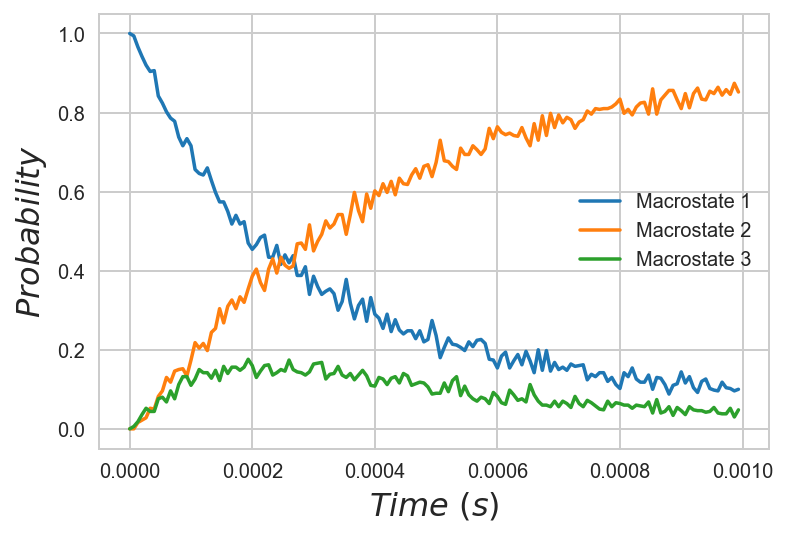

In [27]:
# Draw the population of macrostate at each point by assessment of closes PP matrix

import matplotlib.pyplot as plt
import seaborn as sns

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
sns.set(style='whitegrid', palette=colors, rc={'axes.labelsize': 16})

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

t = np.arange(0, 0.001,0.001/150)

print(len(t))
print(len(TimeCollector))
# Smellir upp grunn
fig, ax = plt.subplots(1, 1)
# Setur merkingar a asa
ax.set_xlabel(r'$Time \ ( s )$')
ax.set_ylabel(r'$Probability$');

dis = {}
for i in range(len(TimeCollector[0])):
    dis[i] = []
        
for j in range(len(TimeCollector)):    
    for i in range(len(TimeCollector[0])):
        dis[i].append(TimeCollector[j][i])

for i in range(len(dis)):
    _ = ax.plot(t, dis[i]/sum(TimeCollector[i]))
#ax.set_xscale('log')
ax.legend(('Macrostate 1', 'Macrostate 2', 'Macrostate 3'), loc='center right');
plt.savefig('TrajectoriesToMacroStates_WolfeCase_150steps_500loops.png', bbox_inches='tight')

i og j: 0 0
i og j: 0 1
i og j: 0 2
i og j: 1 0
i og j: 1 1
i og j: 2 0
i og j: 2 1
i og j: 3 0
i og j: 3 1
i og j: 4 0
i og j: 4 1
i og j: 5 0
i og j: 5 1
i og j: 6 0
i og j: 6 1
i og j: 7 0
i og j: 7 1
i og j: 8 0
i og j: 8 1
i og j: 8 2
i og j: 9 0
i og j: 9 1
i og j: 10 0
i og j: 10 1
i og j: 10 2
i og j: 11 0
i og j: 11 1
i og j: 12 0
i og j: 12 1
i og j: 13 0
i og j: 13 1
i og j: 13 2
i og j: 14 0
i og j: 14 1
i og j: 15 0
i og j: 15 1
i og j: 15 2
i og j: 16 0
i og j: 16 1
i og j: 17 0
i og j: 17 1
i og j: 17 2
i og j: 18 0
i og j: 18 1
i og j: 18 2
i og j: 19 0
i og j: 19 1
i og j: 19 2
i og j: 20 0
i og j: 20 1
i og j: 21 0
i og j: 21 1
i og j: 21 2
i og j: 22 0
i og j: 22 1
i og j: 22 2
i og j: 23 0
i og j: 23 1
i og j: 23 2
i og j: 24 0
i og j: 24 1
i og j: 24 2
i og j: 25 0
i og j: 25 1
i og j: 25 2
i og j: 26 0
i og j: 26 1
i og j: 26 2
i og j: 27 0
i og j: 27 1
i og j: 27 2
i og j: 28 0
i og j: 28 1
i og j: 28 2
i og j: 29 0
i og j: 29 1
i og j: 29 2
i og j: 30 0
i og j: 